## Load modules and functions

In [1]:
import obspy
import numpy as np
from scipy.optimize import minimize
from obspy import UTCDateTime
import matplotlib.pyplot as plt
from obspy import read, read_inventory
from scipy.optimize import minimize, differential_evolution


# Find decimation steps
def find_min_factors(A, B):
    if A < B or B == 0:
        return None  # Cannot reduce A to a smaller B using division
    queue = [(A, [])]  # (current value, list of factors used)
    while queue:
        current, factors = queue.pop(0)
        if current == B:
            return factors  # Found the optimal sequence
        for f in range(2, 11):  # Factors from 2 to 10
            if current % f == 0:  # Ensure divisibility
                queue.append((current // f, factors + [f]))
    return None  # If no solution is found

# Decimate trace
def decimate_to_target(trace, target_sampling_rate):
    factors = find_min_factors(int(trace.stats.sampling_rate), int(target_sampling_rate))
    if factors is None:
        raise ValueError("Cannot decimate to the target sampling rate using factors from 2 to 10.")
    for factor in factors:
        trace.decimate(factor, no_filter=True)  # no_filter=True prevents distortion
        trace.detrend(type = 'demean'); trace.detrend(type = 'linear')
    return trace

# Spectra calculation
def SpectraCalc(tr,freqmin,freqmax):
    n = len(tr)
    f = np.fft.fftfreq(n, tr.stats.delta)
    magnitude = np.abs(np.fft.fft(tr.data))
    mask = (f >= freqmin) & (f <= freqmax) 
    f = f[mask]; magnitude = magnitude[mask];
    return magnitude, f

# Brune Source model and cost function
def BruneSource(X, F, tt):
    Wo, Fc, Q = X
    W = Wo * np.exp(-np.pi * F * tt / Q) / (1 + (F / Fc)**2)
    return W

def BoatwrightSource(X, F, tt):
    Wo, Fc, Q = X
    W = Wo * np.exp(-np.pi * F * tt / Q) / ((1 + (F / Fc)**4)**0.5)
    return W

def CostFunction(X, SD, F, tt, model):
    if model == 1:
        fmod = BruneSource(X, F, tt)
    else:
        fmod = BoatwrightSource(X, F, tt)
    SDlog = np.log10(SD)
    fmodLog = np.log10(fmod)
    residuals = SDlog - fmodLog
    cost = np.mean(residuals**2)
    return cost

# Use global optimization (differential evolution) for better results
def optimize_parameters(SD, F, tt, model, bounds):
    result = differential_evolution(CostFunction, bounds=bounds, args=(SD, F, tt, model))
    return result.x

## Inputs

In [2]:
# Data
dataFile = "TEST.m"

# Instrument response
instResponse = "dataless.seed"
rm_Resp = 1 # Remove response? 1 = YES, else = NO.
pre_filt = [0.001, 0.005, 45, 50] # Pre-filter values

# Brune or Boatwright
brune = 0 # 1 = Brune, else = Boatwright
##### You must also set bounds for optimization (lb, ub). These can be found in the code below.

# Set freq range of interest for models
freqmin = 0.005
freqmax = 1
target_sampleFreq = 25

# Noise and signal start and end times
signalStart = UTCDateTime('2020-10-19T21:06:00')
signalEnd = UTCDateTime('2020-10-19T21:07:00')
noiseStart = UTCDateTime('2020-10-19T21:01:00')
noiseEnd = UTCDateTime('2020-10-19T21:02:00')

# Set Vp, rho, and distance for magnitude calculation
radiation_pattern_correction = 0.44
rho = 2800
vp = 6000
D = 71*111*1000

## Data pre-processing

In [3]:
# Read and trim data
st = obspy.read(dataFile)
inv = read_inventory(instResponse)

# Signal
tr = st[0].copy()
tr.trim(starttime = signalStart,endtime = signalEnd)
tr.detrend(type = 'demean')
tr.detrend(type = 'linear')
tr.taper(0.1)
if rm_Resp == 1:
    tr.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP")
tr = decimate_to_target(tr,target_sampleFreq)
tr.taper(0.1)

# Noise
trNoise = st[0].copy()
trNoise.trim(starttime = noiseStart,endtime = noiseEnd)
trNoise.detrend(type = 'demean')
trNoise.detrend(type = 'linear')
trNoise.taper(0.1)
if rm_Resp == 1:
    trNoise.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP")
trNoise = decimate_to_target(trNoise,target_sampleFreq)
trNoise.taper(0.1)
tt = trNoise.stats.sampling_rate

## Spectral analysis

C:\Users\tober\AppData\Local\Temp\ipykernel_24156\3355916145.py:60: RuntimeWarning: divide by zero encountered in log10
  fmodLog = np.log10(fmod)
C:\Users\tober\anaconda3\envs\py39\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


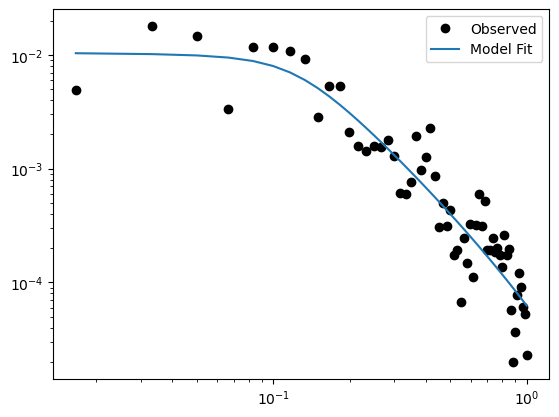

Boatwright Source Model:
Best-fit parameters (Wo, Fc, Q): [1.05417422e-02 1.23063825e-01 8.33922165e+01]
Magnitude = 8.75


In [4]:
# Calculate spectra
[Signal,f] = SpectraCalc(tr,freqmin,freqmax) # Spectra calculation
[Noise,fn] = SpectraCalc(trNoise,freqmin,freqmax)
Magnitude = Signal - Noise
if not np.array_equal(fn, f):  # Checks if X and Y arrays are identical
    raise ValueError("Frequnies of signal and noise are not identical!")
    
## Fit model
# Set upper and lower bounds for the parameters [Wo, Fc, Q]
lb = [0, 0, 0]  # Lower bounds
ub = [max(Magnitude), 1, 500]  # Upper bounds
bounds = [(lb[i], ub[i]) for i in range(len(lb))]
# Run optimization
best_fit_parameters = optimize_parameters(Magnitude, f, tt, brune, bounds)

# Plot results
if brune == 1:
    fmod = BruneSource(best_fit_parameters, f, tt)
else:
    fmod = BoatwrightSource(best_fit_parameters, f, tt)
plt.loglog(f, Magnitude, 'ko', label='Observed')
plt.loglog(f, fmod, label='Model Fit')
plt.legend()
plt.show()
if brune == 1:
    print("Brune Source Model:")
else:
    print("Boatwright Source Model:")
print("Best-fit parameters (Wo, Fc, Q):", best_fit_parameters)
Wo = best_fit_parameters[1]
Mo = 4*np.pi*rho*(vp**3)*D*Wo/radiation_pattern_correction;
Mw = (2/3)*(np.log10(Mo) - 9.1);
Fc = best_fit_parameters[2]
print('Magnitude = {:.2f}'.format(Mw))